<a href="https://colab.research.google.com/github/kithmini-wijesiri/sample_projects/blob/master/nonlinear_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note we need to upload the following files.

ellipse_2class_data.csv

galileo_ramp_data.csv

noisy_sin_sample.csv


In [ ]:
# basic imports
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
datapath = './'

# import autograd wrapped numpy
import autograd.numpy as np

In [ ]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w,version):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice

        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        if version == 'full':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # normalize components
        if version == 'component':
            component_norm = np.abs(grad_eval) + 10**(-8)
            grad_eval /= component_norm

        if version == 'none':
            grad_eval = grad_eval

        # take gradient descent step
        w = w - alpha*grad_eval

    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(g(w))
    return weight_history,cost_history

In [ ]:
# standard normalization function - with nan checker / filler in-er
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.nanmean(x,axis = 1)[:,np.newaxis]
    x_stds = np.nanstd(x,axis = 1)[:,np.newaxis]

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # fill in any nan values with means
    ind = np.argwhere(np.isnan(x) == True)
    for i in ind:
        x[i[0],i[1]] = x_means[i[0]]

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer
    return normalizer,inverse_normalizer

##**Modeling a wave**

Here we have a nonlinear regression dataset. Because of the wavy appearance of this data, we can propose a nonlinear model consisting of a sine function
$f(x) = sin(v_0 + x v_1)$ parameterized by tunable weights $v_0, v_1$, with our regression model given as

model(x, $\Theta$) = $w_0 + f(x) w_1)$, where $\Theta = \{w_0, w_1, v_0, v_1\}$.



In [ ]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:]

# keep the original x
x_org = x

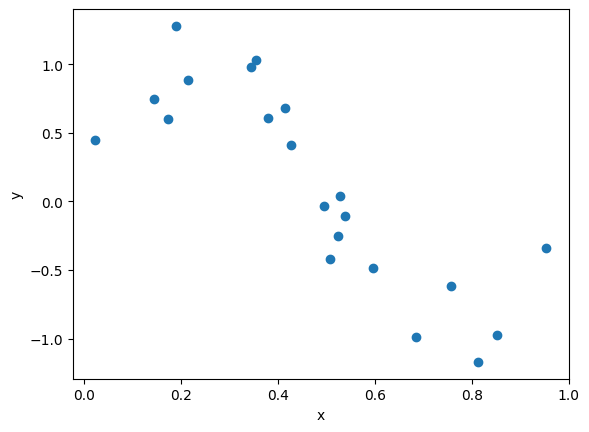

In [ ]:
import matplotlib.pyplot as plt
# Plot the scatter plot
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# the feature transformation
def feature_transforms(x,w):
    # calculate feature transform
      f = np.sin(w[0] + np.dot(x.T,w[1:])).T
      return f

# an implementation of our model employing a nonlinear feature transformation
# implement the following function
def model(x,w):
    # feature transformation
    f = feature_transforms(x, w[0])
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

# an implementation of the least squares cost function for linear regression
# implement the following function
def least_squares(w):
  # compute the least squares cost
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))


In [ ]:
normalizer,inverse_normalizer = standard_normalizer(x)
x = normalizer(x)
np.random.seed(5819)
# parameters for our two runs of gradient descent
g = least_squares; w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)]);
max_its = 500; alpha_choice = 10**(-1)

weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, 'none')

Next we plot the cost function history.

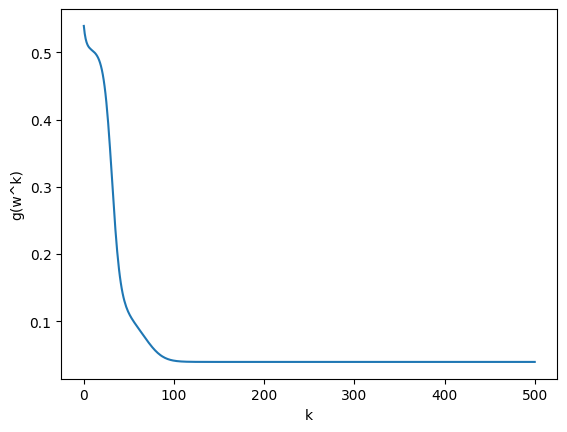

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cost_history);
plt.xlabel("k");
plt.ylabel("g(w^k)");
plt.show()

We now plot the model together with the original data.

In [ ]:
def normalize_data(data):
    # calculate mean and standard deviation of the data
    mu = np.mean(data)
    sigma = np.std(data)

    # normalize the data using z-score normalization
    data_normalized = (data - mu) / sigma

    return data_normalized

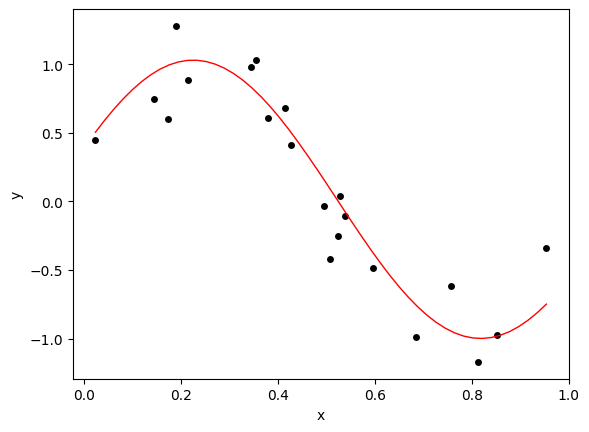

In [ ]:
# plot data with linear fit
s = np.linspace(np.min(x_org),np.max(x_org))[np.newaxis, :]
ind = np.argmin(cost_history)
w = weight_history[ind]

# calculate t
s_normalized = normalize_data(s)
t = model(s_normalized, w)

plt.plot(s[0],t[0],linewidth = 1,c='r')
plt.scatter(x_org,y,linewidth = 1,c='k',edgecolor='w')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

##**Galileo’s experiment**

In [ ]:
# load data
csvname = datapath + 'galileo_ramp_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:]

# keep the original x
x_org = x

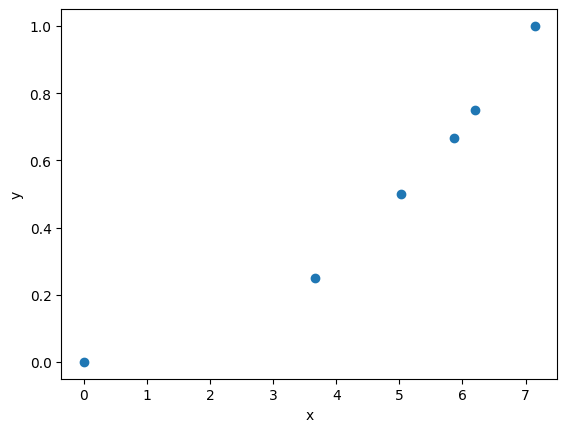

In [ ]:
import matplotlib.pyplot as plt
# Plot the scatter plot
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# feature transform
# implement the following function
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])
    return f

In [ ]:
# an implementation of our model employing a nonlinear feature transformation
# implement the following function
def model(x,w):
    f = feature_transforms(x)
    a = w[0] + np.dot(f.T, w[1:])
    return a.T

In [ ]:
normalizer,inverse_normalizer = standard_normalizer(x)
x = normalizer(x)
np.random.seed(5819)
# parameters for our two runs of gradient descent
g = least_squares; w = 0.1*np.random.randn(3,1);max_its = 50; alpha_choice = 10**(-1);

weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, 'none')

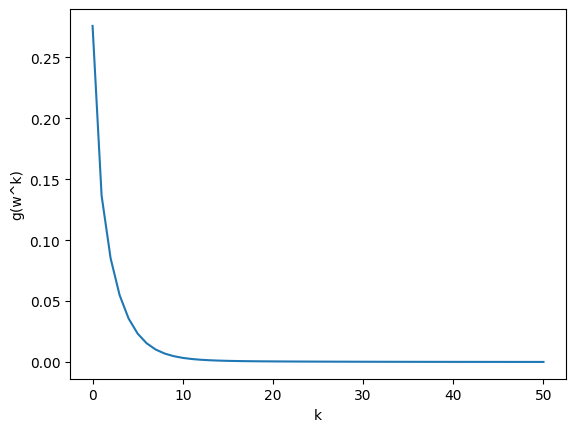

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cost_history);
plt.xlabel("k");
plt.ylabel("g(w^k)");
plt.show()

In [ ]:
def normalize_data(data):
    # calculate mean and standard deviation of the data
    mu = np.mean(data)
    sigma = np.std(data)

    # normalize the data using z-score normalization
    data_normalized = (data - mu) / sigma

    return data_normalized

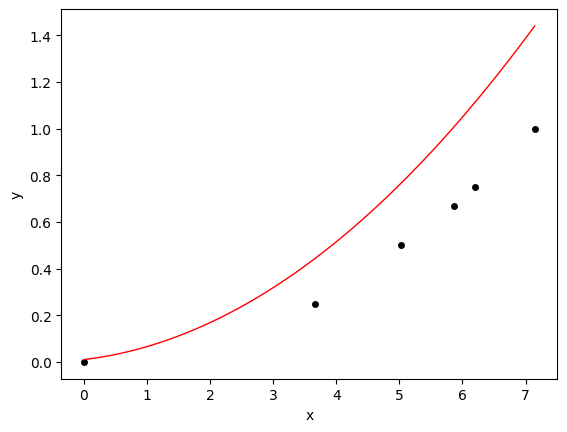

In [ ]:
# plot data with linear fit
s = np.linspace(np.min(x_org),np.max(x_org))[np.newaxis, :]
ind = np.argmin(cost_history)
w = weight_history[ind]

# calcuate t
s_normalized = normalize_data(s)
t = model(s_normalized, w)

plt.plot(s[0],t[0],linewidth = 1,c='r')
plt.scatter(x_org,y,linewidth = 1,c='k',edgecolor='w')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

##**An elliptical decision boundary**



In [ ]:
# load data
csvname = datapath + 'ellipse_2class_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:]

In [ ]:
x.shape, y.shape

((2, 150), (1, 150))

In [ ]:
# an elliptical feature transformation
# implement the following function
def feature_transforms(x):
    # calculate feature transform
    f = x**2
    return f


In [ ]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):
    f = feature_transforms(x)
    a = w[0] + np.dot(f.T, w[1:])
    return a.T


In [ ]:
# an implementation of the softmax cost
def softmax(w):
  # compute the least squares cost
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(np.size(y))


In [ ]:
### cost functions ###
# count misclassifications
def counting_cost(w,x,y):
 y_pred = np.sign(model(x,w)) # predicted labels
 num_misclassifications = np.sum(y_pred != y) # number of misclassifications
 return num_misclassifications/float(np.size(y)) # misclassification rate


In [ ]:
np.random.seed(5819)
# parameters for our two runs of gradient descent
g = softmax; normalize = 'none'
w = 0.1*np.random.randn(3,1); max_its = 1000; alpha_choice = 10**(0)

weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,'none')

In [ ]:
count_history = [counting_cost(v, x, y) for v in weight_history]

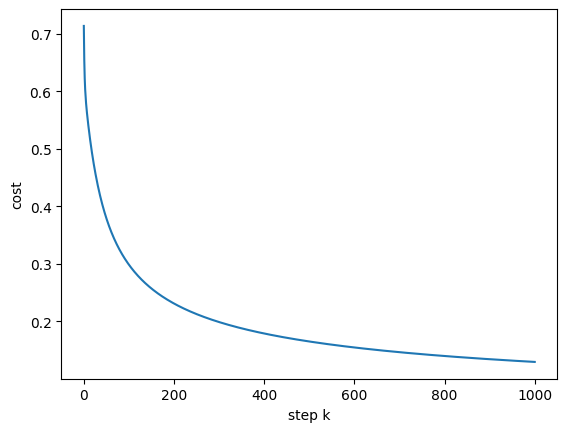

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(cost_history));
plt.xlabel("step k");
plt.ylabel("cost");
plt.show()

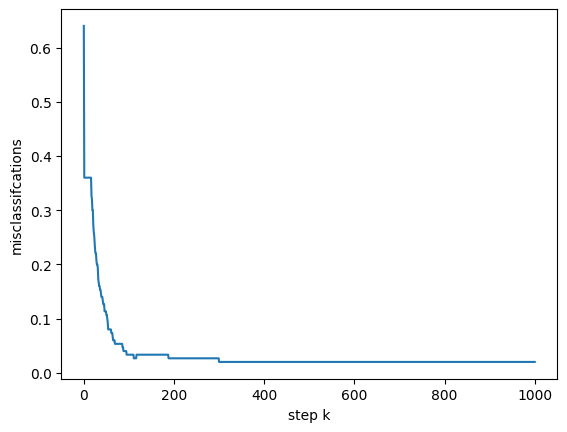

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(count_history))
plt.xlabel("step k")
plt.ylabel("misclassifcations")
plt.show()

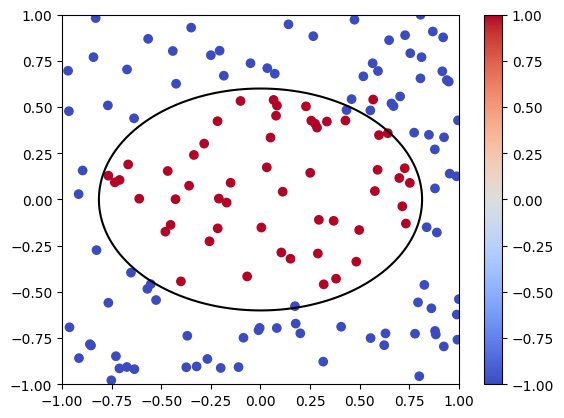

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of the data
plt.scatter(x[0, :], x[1, :], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()

# Define the range of x1 and x2 values to use for the decision boundary plot
xx, yy = np.meshgrid(np.linspace(-1, 1, num=100), np.linspace(-1, 1, num=100))
zz = np.zeros_like(xx)

w = weight_history[-1]
# Calculate the decision boundary for each point in the meshgrid
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        xxij = xx[i, j]
        yyij = yy[i, j]
        zzij = model(np.array([xxij, yyij]), w)
        zz[i, j] = zzij

# Plot the decision boundary as a contour plot
plt.contour(xx, yy, zz, levels=[0], colors='black')

# Display the plot
plt.show()